# Metaheuristics 

In [1]:
import os
from Pylice_def.data import page as data_page
import Pylice_def.data.preprocess as prep
from Pylice_def.forecast import modelling
from Pylice_def.forecast import forecasts
import pandas as pd 
import numpy as np 
from Pylice_def.queing import simulation as sim
from Pylice_def.queing import page as q_page
from Pylice_def.shift_scheduling import preprocess as sched_prep
from Pylice_def.shift_scheduling import page as shift_page
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import datetime as dt
import itertools as itr
import random as rd
from copy import copy
from tqdm import tqdm
import os
from Pylice_def.data import page as data_page
import Pylice_def.data.preprocess as prep
from Pylice_def.forecast import modelling
from Pylice_def.forecast import forecasts
import pandas as pd 
import numpy as np 
from Pylice_def.queing import simulation as sim
from Pylice_def.queing import page as q_page

from Pylice_def.shift_scheduling import preprocess as sched_prep
from Pylice_def.shift_scheduling.optimization import pylice_opt_model_hard, optimize_hard
from Pylice_def.shift_scheduling import page as shift_page
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.patches import Patch

def optimization_preprocess(n_weeks, earliest_shift,latest_shift, allowed_lens, minimum_night, minimum_day, demand, f):
    allowed_lens = set(list(map(int, allowed_lens)))
    ts = sched_prep.horizon_timestamps(n_weeks,f)
    possible_shifts, starts_ends = sched_prep.create_possible_shifs(ts, sched_prep.create_forbidden_shifts(earliest_shift,latest_shift, f),allowed_lens, f)
    shifts_info = sched_prep.compute_shift_statistics(possible_shifts, f)
    shifts_info["Start_end"] = starts_ends
    possible_shifts = sched_prep.change_column_names(possible_shifts,ts,f)
    min_demand = sched_prep.create_min_demand(ts, minimum_night, minimum_day, f)
    shift_costs = shifts_info["cost"].copy(deep = True)
    shift_costs = shift_costs.to_dict()
    S = possible_shifts.index.tolist()
    ts = possible_shifts.columns.tolist()
    demand.index = ts
    min_demand.index = ts
    demand = pd.concat([demand, min_demand]).groupby(level=0).max().sort_index().to_dict()["Staffing_level"]
    shift_day_match_start, shift_day_match_end = sched_prep.match_starting_ending(ts, shifts_info)
    day_shift_match = sched_prep.create_coverage(possible_shifts)
    return ts, S, demand, shift_costs,day_shift_match, shift_day_match_start, shift_day_match_end, possible_shifts, shifts_info



def tabularize_results(model, shift_stats, ts_horizon, overlap, shift_lenghts, f):
    choosen = []
    for i in model:
        choosen.append((i[0],int(i[1] > 0) , i[1]))
    choosen = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
    choosen = choosen.loc[(choosen["selected"] > 0) & (choosen["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)
    choosen["start_num"] = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][0], choosen.index.tolist()))
    new_end = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][-1] +1 , choosen.index.tolist()))
    for n, i in enumerate(new_end):
        if i == len(ts_horizon):
            new_end[n] = 0
    choosen["end_num"] = new_end
    choosen["start"] = choosen["start_num"].apply(lambda x: shift_page.from_num_to_date(x, f))
    choosen["end"] = choosen["end_num"].apply(lambda x :shift_page.from_num_to_date(x, f))
    choosen["len"] = (choosen["end"] - choosen["start"]).dt.seconds/(60*f)
    choosen = choosen[["staff", "start_num", "end_num", "len", "start", "end"]]
    choosen.sort_values("start_num", inplace = True)
    target = dt.timedelta(minutes = overlap)
    max_allowed_len = max(shift_lenghts)
    ##
    # shifts = shift_page.create_overlap(choosen, target, max_allowed_len)
    shifts = list(map(list, choosen.reset_index().to_numpy()))
    shifts = pd.DataFrame(shifts)
    ##
    shifts.columns = choosen.reset_index(names= ["Shift_name"]).columns
    shifts.drop("len", axis = 1, inplace = True)
    shifts.set_index("Shift_name", inplace = True)
    shifts["start-end"] = shifts["start"].dt.time.astype(str) +  " - " + shifts["end"].dt.time.astype(str)

    layover = shifts[shifts["start_num"] > shifts["end_num"]].index.tolist()
    for ind in layover:
        shifts.loc[f"{ind}-->"] =   shifts.loc[ind, "staff"],\
                                    shifts.loc[ind, "start_num"],\
                                    0,\
                                    shifts.loc[ind, "start"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "start-end"]
        
        shifts.loc[f"-->{ind}"] =   shifts.loc[ind, "staff"],\
                                    0,\
                                    shifts.loc[ind, "end_num"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "end"],\
                                    shifts.loc[ind, "start-end"]
        shifts.drop(ind, inplace = True)

    shifts["len"] = (shifts["end"] - shifts["start"]).dt.seconds/(60*15)
    coverage = shifts[["staff", "start", "end"]].copy()
    ts_ = list(pd.date_range(start = "2023-01-01 00:00:00", end= "2023-01-08 00:00:00", freq = "15min"))
    shifts["start_num"] = shifts["start"].apply(lambda x: (ts_.index(x)))
    shifts.drop(["start", "end"], axis = 1, inplace = True)
    layover = shifts.loc[shifts["len"] < 0].index.tolist()
    for i in layover:
        shifts.loc[i, "len"] = len(ts_) - shifts.loc[i, "start_num"] ###
    shifts['color'] = shifts.apply(lambda df: shift_page.color(df), axis=1)
    shifts.reset_index(names = ["Shift_name"], drop = False, inplace= True)
    shifts.sort_values("start-end", inplace = True, ascending= False)
    print(f"Maximum shift length is respected: {(shifts.len > 4* max_allowed_len).unique().tolist() == [False]}")
    shifts["end_num"] = shifts["start_num"] + shifts["len"] 
    return shifts, coverage


def plot_staffing_requirements(demand, params,t):
        q = 60//t
        demand["how"] = demand.reset_index(inplace = False).index
        axs = plt.subplot()
        y_max = demand.Staffing_level.max() +2 
        y_min = max(0, demand.Staffing_level.min() -2) 
        plt.plot(demand["how"], demand["Staffing_level"],zorder = 2, color = "green")
        for day in range(0,(24*7*q), 24*q):
                axs.vlines(x = day, ymin = 0, ymax =y_max + 0.2, color = "blue", zorder = 1, alpha = .4, linestyles= "dashed")
        # axs.hlines(y = 3, xmin=demand["how"].min(), xmax = demand["how"].max(), color = "tomato", zorder = 2)
        axs.set_xticks(list(range(1,(24*7*q)+1, 24*q)))
        xticks_minor = list(range(0 ,(24*7*q)+1,q))
        axs.set_xticks(xticks_minor, minor=True)
        axs.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
        axs.set_xlim(xmin= 0, xmax = 24*7*q)
        axs.set_ylim(ymin= 1, ymax = y_max -1)
        axs.set_facecolor("lightgray")
        axs.set_ylabel("Number of employees")
        axs.set_xlabel("Average Week")
        plt.show()
        print("Call Type:", call_type)
        for p in params.keys():
                text = f"{p.title()}: {params[p][call_type]}"
                if p in {"asa", "aht"}:
                        text += " seconds"
                elif p in {"max_occupancy", "shrinkage", "service_level"}:
                        text += "%"
                print(text)


def plot_resulting_schedule(result, assigned, t):
    p = 60//15
    c_dict = {'day':'#E64646', 'night':'#E69646', "evening" : "green"}
    colors = {"background" : "lightgray", "shifts_colors" : c_dict, "staffing levels" : "green", "assigned levels" : "red", "vlines" : "blue"}

    fig, axs = plt.subplots(2, 1, figsize=(18,12), sharex= False)
    bars = axs[0].barh(result["start-end"], result.len, left=result.start_num, zorder = 2, color = result.color)
    y_max = 0
    y_min = 0
    for rect in bars:
        if rect.get_y() + rect.get_height() > y_max:
            y_max = rect.get_y() + rect.get_height()
        if rect.get_y() - rect.get_height() < y_min:
            y_min = rect.get_y() - rect.get_height()

    # for idx, row in result.iterrows():
    #     axs[0].text(row.start_num + 1, row["start-end"], 
    #             f"{row.Shift_name.replace('-', '').replace('>', '')}", 
    #             va='center', alpha=0.8)

    legend_elements = [Patch(facecolor= colors["shifts_colors"][i], label=i)  for i in colors["shifts_colors"]]
    axs[0].legend(handles=legend_elements, facecolor = colors["background"], framealpha=0)

    for day in range(0,(24*7*p), 24*p):
        axs[0].vlines(x = day, ymin = y_min, ymax =y_max + 0.2, color = colors["vlines"], zorder = 1, alpha = .5)
    axs[0].set_xticks(list(range(12*p,(24*7*p), 24*p)))
    axs[0].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

    xticks_minor = list(range(24*7*p))
    axs[0].set_xticks(xticks_minor, minor=True)
    axs[0].set_ylim(ymin= y_min, ymax = y_max + 0.2)
    axs[0].set_xlim(xmin= 0, xmax = 24*7*p)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].set_facecolor(colors["background"])

    axs[1].plot(assigned.index, assigned.Assigned,zorder = 2, color = colors["assigned levels"])
    axs[1].plot(assigned.index, assigned.Staffing_level,zorder = 1, color = colors["staffing levels"])
    axs[1].fill_between(assigned.index, assigned.Staffing_level, color = colors["staffing levels"], zorder = 1)
    for day in range(0,(24*7*4), 24*4):
        axs[1].vlines(x = day, ymin = 0, ymax =max(assigned.Assigned.max(), assigned.Staffing_level.max()) +0.2, color = colors["vlines"], zorder = 1, alpha = .5)
    axs[1].set_xticks(list(range(12*4,(24*7*4), 24*4)))
    xticks_minor = list(range(0 ,24*7*4,4))
    axs[1].set_xticks(xticks_minor, minor=True)
    axs[1].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    axs[1].set_xlim(xmin= 0, xmax = 24*7*4)
    axs[1].set_ylim(ymin= 0, ymax = max(assigned.Assigned.max(), assigned.Staffing_level.max()))
    axs[1].spines['top'].set_visible(False)
    axs[1].set_facecolor(colors["background"])
    axs[1].set_ylabel("Number of employees")
    axs[1].set_xlabel("Average Week")
    # fig.patch.set_facecolor(colors["background"])
    plt.subplots_adjust(wspace=0, hspace =0)
    return fig


timeframe = 30
horizon = 9
all_data = []
for file in os.listdir(f"..\data\List_Raw\\112_Soer_Oest"):
    file = f"..\\data\\List_Raw\\112_Soer_Oest\\" + file
    all_data.append(data_page.import_file(file))


call_types = ["112","02800"]
### Prepare
a, all_data, b, c = prep.prepare_data(all_data, timeframe)
for n in range(len(all_data)):
    data = all_data[n]
    call_type = call_types[n]
    ### Forecast
    x_train, y_train, x_test, y_test = modelling.custom_train_test_split(data.copy(deep = True), s_start= pd.to_datetime("2023-01-07 00:00:00"), horizon = 9)
    model = modelling.xgb_model()
    model.fit(x_train, y_train)
    print(modelling.mae(y_train,np.round(model.predict(x_train).flatten())))
    print(modelling.mae(y_test,np.round(model.predict(x_test).flatten())))
    X_train = data.copy(deep = True)
    Y_train = X_train.pop("Calls")
    model.fit(X_train, Y_train)
    print(modelling.mae(Y_train,np.round(model.predict(X_train).flatten())))

    from_date = pd.to_datetime("2023-01-07 00:00:00")
    future_dates = forecasts.create_horizon_dates(from_date, horizon, timeframe)
    future_data = forecasts.create_horizon_data(future_dates)
    predictions = model.predict(future_data)
    predictions = forecasts.create_prediction_output(future_dates, predictions, call_type)

    # DEFAULT NO WRAP UP -OK 
    # params = {"service_level" : {"112" : 90, "02800" : 80},
    #           "shrinkage" : {"112" : 30, "02800" : 30},
    #           "max_occupancy" : {"112" : 80, "02800" : 80}, #85
    #           "asa" : {"112" : 20, "02800" : 180},
    #           "aht": {"112" : 120, "02800" : 200}} #120 , 180

    # DEFAULT SCENARIO PARAMETERS - OK 
    params = {"service_level" : {"112" : 90, "02800" : 80},
            "shrinkage" :     {"112" : 30, "02800" : 30},
            "max_occupancy" : {"112" : 80, "02800" : 80},
            "asa" :           {"112" : 20, "02800" : 180},
            "aht":            {"112" : 320,"02800" : 380}}

    # PUBLIC EVENTS SCENARIO PARAMETERS - OK 
    # params = {"service_level" : {"112" : 95, "02800" : 80},
    #         "shrinkage" :     {"112" : 25, "02800" : 25},
    #         "max_occupancy" : {"112" : 80, "02800" : 75},
    #         "asa" :           {"112" : 15, "02800" : 200},
    #         "aht":            {"112" : 350,"02800" : 380}}

    # # HOLIDAYS EVENTS SCENARIO PARAMETERS - OK 
    # params = {"service_level" : {"112" : 90, "02800" : 80},
    #         "shrinkage" :     {"112" : 35, "02800" : 35},
    #         "max_occupancy" : {"112" : 75, "02800" : 75},
    #         "asa" :           {"112" : 15, "02800" : 180},
    #         "aht":            {"112" : 280,"02800" : 340}}

    service_level = value= params["service_level"][call_type]
    asa = value = params["asa"][call_type]
    aht = params["aht"][call_type]
    shrinkage = params["shrinkage"][call_type]
    max_occupancy = params["max_occupancy"][call_type]
    aht  = [int(aht//60)]
    asa  = [asa/60]
    shrinkage  = [shrinkage/100]
    service_level  = [service_level/100]
    max_occupancy  = [max_occupancy/100]
    final_staffing_levels = dict()
    sub = predictions.copy(deep = True)
    sub = q_page.prepare_CyclicWeek(sub, Type = call_type)
    staffing_levels = sim.compute_staffing_levels(  demand = sub,
                                                    aht = aht,
                                                    planning_period = [timeframe],
                                                    asa = asa,
                                                    shrinkage = shrinkage,
                                                    service_level = service_level,
                                                    max_occupancy = max_occupancy,
                                                    Type = call_type)


    if n == 0:
        demand_112 = pd.DataFrame(staffing_levels["Staffing Level"]).rename({"Staffing Level" : "Staffing_level"}, axis = 1)
    else:
        demand_02  = pd.DataFrame(staffing_levels["Staffing Level"]).rename({"Staffing Level" : "Staffing_level"}, axis = 1)


demand = demand_112 + demand_02
demand["112"] = demand_112["Staffing_level"]
demand["02800"] = demand_02["Staffing_level"]
# plot_staffing_requirements(demand, params,timeframe)
# demand["Staffing_level"].plot()
# demand["02800"].plot()
# plt.show()


Demand = demand.copy()
earliest=  6
latest = 22
minimum_night = 3
minimum_day = 4
teamsize = 3
max_cap = 15
S_max =35 
shift_lenghts = [6,7,8,9,10]
overlap = 45
##################
shift_lenghts = list(map(lambda x: x*(60//timeframe), shift_lenghts))
ts_horizon, S,\
    demand, shift_costs,\
        t_s_cov, starting_shfits,\
            ending_shifts, possible_shifts,\
                shift_stats = optimization_preprocess(n_weeks = 1,
                                                    earliest_shift = earliest,
                                                    latest_shift = latest,
                                                    allowed_lens = shift_lenghts,
                                                    minimum_night= minimum_night,
                                                    minimum_day = minimum_day,
                                                    demand = demand.copy(),
                                                    f = timeframe)

time_t = ts_horizon
p_shifts = S
teamsize = teamsize
cap_max = max_cap
shift_cost = shift_costs
# day_shift_match= t_s_cov
shift_day_match_start= starting_shfits
shift_day_match_end = ending_shifts

def create_range(cell, times = time_t):
    start, end = cell[0], cell[1] + 1
    if start < end:
        return list(range(start, end))
    else: 
        return list(range(start, len(times))) + list(range(0, end))
    
    
    
shift_stats["Start_end"] = shift_stats["Start_end"].apply(lambda x : create_range(x, time_t))
meta_data = shift_stats.copy()
meta_dict = meta_data["Start_end"].to_dict()

def find_shift(start_time : str|int = None, end_time : str|int = None, length : int = None):
    inv_meta_dict = {str(v): k for k, v in meta_dict.items()}
    if start_time == end_time == length == None:
        raise BaseException("Input Not Valid")
    
    if isinstance(start_time, str) and start_time != None: 
        start_time = time_t.index(start_time)
    
    if isinstance(end_time, str) and end_time != None: 
        end_time = time_t.index(end_time)
    
    if start_time + length != end_time and start_time != None and end_time != None and length != None:
        raise BaseException("Length, start and end do not match")
    try:
        if length == None:
            solution = create_range((start_time, end_time), time_t)
        
        elif end_time == None:
            solution = [i for i in inv_meta_dict.keys() if eval(i)[0] == start_time and len(eval(i)) == length ][0]

        elif start_time == None:
            solution = [i for i in inv_meta_dict.keys() if eval(i)[-1] == end_time and len(eval(i)) == length ][0]
        return inv_meta_dict[solution]
    except: 
        BaseException(f"{solution} does not correspond to any shift")


c:\Users\loren\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


two types


2023-06-12 11:53:44.685 
  command:

    streamlit run c:\Users\loren\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


2.25
2.15
2.15
1.32
1.27
1.32


## Tabu Search w/ Dynamic Tabu List & Influence Aspiration Criteria Pareto 

### Experiment Tabu List 1 - The Move as Tabu

In [2]:
### DEF ----- 
def get_final_objs(solution, cost_df, demand):
    cost =  sum(list(map(lambda x : cost_df[x[0]] * x[1], solution)))
    tmp = shift_stats.reset_index(names = "Shift_name")[["Shift_name", "Start_end"]].copy()
    tmp = pd.merge(pd.DataFrame.from_records(solution).rename(columns = {0:"Shift_name",1:"Assigned", "string" : "Shift_name", "integer" : "Assigned"}), tmp, on = "Shift_name", how = "left")
    tmp = tmp.explode("Start_end")
    tmp["Start_end"] = tmp.Start_end.apply(lambda y: ts_horizon[y])
    tmp["Demand"] = tmp.Start_end.apply(lambda y: demand[y])
    tmp = tmp.groupby("Start_end").agg({"Demand" : "mean", "Assigned" : "sum"})
    tmp["UnderStaff"] = tmp["Demand"] - tmp["Assigned"]
    demand_diff =  tmp.UnderStaff.abs().sum()
    return cost, demand_diff/len(demand)


In [3]:

def create_demand_fv(solution, demand): #make only one function 
    tmp = shift_stats.reset_index(names = "Shift_name")[["Shift_name", "Start_end"]].copy()
    tmp = pd.merge(pd.DataFrame(solution[:-1]).rename(columns = {0:"Shift_name",1:"Assigned", "string" : "Shift_name", "integer" : "Assigned"}), tmp, on = "Shift_name", how = "left")
    tmp = tmp.explode("Start_end")
    tmp["Start_end"] = tmp.Start_end.apply(lambda y: ts_horizon[y])
    tmp["Demand"] = tmp.Start_end.apply(lambda y: demand[y])
    tmp = tmp.groupby("Start_end").agg({"Demand" : "mean", "Assigned" : "sum"})
    tmp["UnderStaff"] = tmp["Demand"] - tmp["Assigned"]
    return tmp.UnderStaff.abs().sum()

def get_objFunc(solution, cost_df,demand, demand_weigth):
    cost_weight = 1 - demand_weigth
    demand_diff_weight = demand_weigth
    minimum_cost = 213727.5 # Max_cap = 15
    maximum_cost = 1070317.5 # Max_cap = 15
    minimum_demand_diff = 361 # Max_cap = 15
    maximum_demand_diff = 3459 # Max_cap = 15, 3459
    cost_normalization_range = maximum_cost - minimum_cost
    demand_diff_normalization_range = maximum_demand_diff - minimum_demand_diff
    cost =  sum(list(map(lambda x : cost_df[x[0]] * x[1], solution)))
    demand_diff = create_demand_fv(solution, demand)
    return 1000 * (cost_weight*((cost - minimum_cost)/cost_normalization_range) + demand_diff_weight*((demand_diff - minimum_demand_diff)/demand_diff_normalization_range))

def get_allocated_for_shift_in_solution(solution, shift):
    return solution[list(map(lambda x: x[0], solution)).index(shift)][1]

def ReplaceShifts(solution0, all_shifts, N = 20):
    shifts_subs = []
    potentialss = []
    for i in solution0:
        if i[1] > 0:
            shifts_subs.append(i[0])
        else:
            potentialss.append(i[0])
    List_of_N = []    
    potentials = set(potentialss)
    for shift in shifts_subs:
        allocated = get_allocated_for_shift_in_solution(solution0, shift)
        replacement = (rd.sample(list(potentials), 1)[0],allocated )
        potentials.remove(replacement[0])
        while (replacement[0], 0) not in solution0.tolist():
            replacement = (rd.sample(list(potentials), 1)[0], allocated)
        List_of_N.append(((shift, allocated), replacement))
    moves_used = {}
    neighbourhood = []
    for i in range(N):
        if len(List_of_N) <= 1:
            continue
        solution = copy(solution0)
        a = rd.randint(min(len(List_of_N), 2),min(6,len(List_of_N)))
        Chosen_Changes = rd.sample(List_of_N, a) # diversification
        for old, new in Chosen_Changes:
            solution[solution.tolist().index(old)] = (solution[solution.tolist().index(old)][0], 0)
            solution[solution.tolist().index((new[0], 0))] = (solution[solution.tolist().index((new[0], 0))][0], new[1])
        neighbourhood.append(solution)
        moves_used[tuple(Chosen_Changes)] = np.array(solution, dtype = [('string', 'U20'), ('integer', int)])
    return np.array(neighbourhood, dtype = [('string', 'U20'), ('integer', int)]), moves_used

def ChangeTeamSize(solution0, teamsize, demand, N = 20):
    # sizes = [teamsize * n for n in range(1,int((max(demand.values())//teamsize )+1))]
    shifts_subs = []
    for i in solution0:
        if i[1] > 0:
            shifts_subs.append(i[0])
    moves_used = {}
    neighbourhood = []
    choosen_shifts = rd.sample(shifts_subs, len(shifts_subs)//2)
    for i in range(N):
        solution = copy(solution0)
        Chosen_Changes = []
        for shift in choosen_shifts:
            # new = (shift, rd.sample(sizes, 1)[0])
            old = (shift, get_allocated_for_shift_in_solution(solution, shift))
            new = (shift, rd.sample([old[1], -old[1]], 1)[0])
            solution[solution.tolist().index(old)] = new
            Chosen_Changes.append((old, new))
        neighbourhood.append(solution)
        moves_used[tuple(Chosen_Changes)] = np.array(solution, dtype = [('string', 'U20'), ('integer', int)])
    return np.array(neighbourhood, dtype = [('string', 'U20'), ('integer', int)]), moves_used

def Number_of_Shifts(solution0, teamsize, all_shifts,meta_dict, N = 20):
    active_shifts_subs = []
    for i in solution0:
        if i[1] > 0:
            active_shifts_subs.append(i[0])

    inactive_shifts_subs = []
    for i in solution0:
        if i[1] == 0:
            inactive_shifts_subs.append(i[0])
    neighbourhood = []
    moves_used = {}
    for i in range(N):
        active_cov = {1}
        inactive_cov = {2}
        solution = copy(solution0)
        Chosen_Changes = []
        while not active_cov.issubset(inactive_cov):
            choosen_to_drop = rd.sample(active_shifts_subs, rd.randint(min(len(active_shifts_subs), 2),min(6,len(active_shifts_subs) )))
            potentials = []
            for shift in choosen_to_drop:
                potentials.extend(inactive_shifts_subs)
            potentials = set(potentials)

            choosen_to_add = rd.sample(inactive_shifts_subs, rd.randint(min(len(inactive_shifts_subs), 2),min(6,len(inactive_shifts_subs) )))
            while len(choosen_to_add) == len(choosen_to_drop):
                choosen_to_add = rd.sample(inactive_shifts_subs, rd.randint(min(len(inactive_shifts_subs), 2),min(6,len(inactive_shifts_subs) )))

            active_cov = set().union(*[set(meta_dict[p]) for p in choosen_to_drop])
            inactive_cov = set().union(*[set(meta_dict[p]) for p in choosen_to_add])
        
        for shift in choosen_to_add:
            new = (shift, teamsize)
            old = (shift, get_allocated_for_shift_in_solution(solution, shift))
            solution[solution.tolist().index(old)] = new
            Chosen_Changes.append((old,new))
        for shift in choosen_to_drop:
            new = (shift, 0)
            old = (shift, get_allocated_for_shift_in_solution(solution, shift))
            solution[solution.tolist().index(old)] = new
            Chosen_Changes.append((old,new))
        neighbourhood.append(solution)
        moves_used[tuple(Chosen_Changes)] = np.array(solution, dtype = [('string', 'U20'), ('integer', int)])
    return np.array(neighbourhood, dtype = [('string', 'U20'), ('integer', int)]), moves_used

def neighbour_move(solution, moves_used):
    for move in moves_used:
        if solution[:-1].tolist() == moves_used[move].tolist():
            try:
                return (move[1], move[0])
            except:
                return (move[0][1], move[0][0])
    raise BaseException("STOOOOOP")

def EnsabledMove(solution0, teamsize, demand, all_shifts ,meta_dict, N = 20):
    All_N_for_i, old_moves = Number_of_Shifts(solution0, teamsize, all_shifts,meta_dict, N)
    new_neighbourhood = []
    moves_used = {}
    for neighbour in All_N_for_i:
        for move in old_moves:
            if neighbour.tolist() == old_moves[move].tolist():
                old_move = move
        new_neighbour, new_move = ChangeTeamSize(neighbour, teamsize, demand, N = 1)
        new_move = list(new_move.keys())[0]
        moves_used[(old_move, new_move)] = np.array(new_neighbour.tolist()[0], dtype = [('string', 'U20'), ('integer', int)])
        new_neighbourhood.append(new_neighbour.tolist()[0])
    return np.array(new_neighbourhood, dtype = [('string', 'U20'), ('integer', int)]), moves_used

def plot_staffing_requirements(demand, params):
        demand["how"] = demand.reset_index(inplace = False).index
        axs = plt.subplot()
        y_max = demand.Staffing_level.max() +2 
        y_min = max(0, demand.Staffing_level.min() -2) 
        plt.plot(demand["how"], demand["Staffing_level"],zorder = 1, color = "green")
        for day in range(0,(24*7*4), 24*4):
                axs.vlines(x = day, ymin = y_min, ymax =y_max + 0.2, color = "blue", zorder = 1, alpha = .4, linestyles= "dashed")
        axs.set_xticks(list(range(12*4,(24*7*4), 24*4)))
        xticks_minor = list(range(0 ,24*7*4,4))
        axs.set_xticks(xticks_minor, minor=True)
        axs.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
        axs.set_xlim(xmin= 0, xmax = 24*7*4)
        axs.set_ylim(ymin= y_min, ymax = y_max)
        axs.set_facecolor("lightgray")
        axs.set_ylabel("Number of employees")
        axs.set_xlabel("Average Week")
        plt.show()
        print("Call Type:", call_type)
        for p in params.keys():
                text = f"{p.title()}: {params[p][call_type]}"
                if p in {"asa", "aht"}:
                        text += " seconds"
                elif p in {"max_occupancy", "shrinkage", "service_level"}:
                        text += "%"
                print(text)

from matplotlib.patches import Patch


In [4]:
build_initial = []
end = None
iterr = 0
start = f"Monday {str(earliest).zfill(2)}:00:00"
while start in list(shift_day_match_start.keys()):
    pox = list(shift_day_match_start[start])
    shift = rd.sample(pox, 1)[0]
    end = ts_horizon[shift_stats.loc[shift, "Start_end"][-1]]
    while end not in list(shift_day_match_start.keys()):
        pox.remove(shift)
        shift = rd.sample(pox, 1)[0]
        end = ts_horizon[shift_stats.loc[shift, "Start_end"][-1]]
    start = end
    build_initial.append(shift)
    if "Sunday 20:30:00" <= start < "Sunday 23:00:00":
        break
build_initial.append(list(set(shift_day_match_start[time_t[shift_stats.loc[build_initial[-1], "Start_end"][-1]]]).intersection(set(shift_day_match_end[f"Monday {str(earliest).zfill(2)}:30:00"])))[0])

In [5]:

build_initial = pd.DataFrame(build_initial).rename(columns = {0: "Shift_name"})
build_initial["coverage"] = build_initial["Shift_name"].apply(lambda x: meta_dict[x])
build_initial = build_initial.explode("coverage").reset_index(drop = True)
build_initial["coverage"] = build_initial["coverage"].apply(lambda x : ts_horizon[x])
build_initial = pd.merge(build_initial, Demand, left_on = "coverage", right_index = True, how = "left")
build_initial["Assigned"] = teamsize * (max(build_initial.Staffing_level.max() // teamsize,1))
build_initial_demand = build_initial.groupby("coverage").agg({"Assigned":"sum", "Staffing_level":"mean", "Assigned":"sum", "Shift_name": "unique"})
build_initial_demand["order"] = list(map(lambda x : ts_horizon.index(x), build_initial_demand.index))
additional_pp = set(map(lambda x: x[0], build_initial_demand.loc[(build_initial_demand.Staffing_level > build_initial_demand.Staffing_level.max()) & (build_initial_demand.Assigned < build_initial_demand.Staffing_level)].sort_values("order").Shift_name))
build_initial.loc[build_initial.Shift_name.isin(additional_pp), "Assigned"] = teamsize * (max(build_initial.Staffing_level.max() // teamsize,1))
assert len(build_initial[["Shift_name", "Assigned"]].drop_duplicates()["Shift_name"].value_counts().unique()) == 1
Initial_Solution = []
for shift, assigned in build_initial[["Shift_name", "Assigned"]].drop_duplicates().to_numpy().tolist():
    Initial_Solution.append((shift, assigned))

for unused in set(S).difference(set(map(lambda y: y[0], Initial_Solution))):
    Initial_Solution.append((unused, 0))


ShiftCosts_df = pd.DataFrame(dict(shift_costs), index=[0])
sum_start_int = get_objFunc(Initial_Solution, ShiftCosts_df, demand, 0.82)
# print("Initial OBJ Fx value: ", int(sum_start_int))

In [6]:

X0 = Initial_Solution
X0 = np.array(X0, dtype = [('string', 'U20'), ('integer', int)])
Initial_For_Final = X0[:] # For printing at the end

print(f'Initial FV: {sum_start_int}')
### RUN ---------------------------------------------------------------------------------------------------------------------------------------------------
Runs = 60
## Tabu List ## 
moves_config = {0: "ReplaceShifts(X0, S)",
                1: "ChangeTeamSize(X0, teamsize = teamsize, demand = demand)",
                2: "Number_of_Shifts(X0, teamsize = teamsize, all_shifts = S, meta_dict = meta_dict)",
                3: "EnsabledMove(X0, teamsize = teamsize, demand = demand, all_shifts = S ,meta_dict = meta_dict)"}

change_move = Runs//len(moves_config.keys()) ##### Change this as part of MDA

Length_of_Tabu_List = np.random.randint(10,30)

Iterations = 1
Tabu_List = []  

Save_Solutions_Here = []


for Iteration in tqdm(range(Runs)):
    All_N_for_i, moves_used = eval(moves_config[int(Iteration//change_move)])
    if len(All_N_for_i) == 0:
        if (Iteration + 1)%5 == 0:
            new_len = np.random.randint(10,30)
            if new_len < Length_of_Tabu_List:
                Tabu_List = Tabu_List[:new_len]
            Length_of_Tabu_List = new_len
        Iterations += 1
        continue
    ObjFct_Values_for_N = np.array([np.concatenate((s, np.array([("Fitness Value" , get_objFunc(s, ShiftCosts_df, demand, 0.82))],  dtype = [('string', 'U20'), ('integer', int)])), axis = 0) for s in All_N_for_i])
    ObjFct_Values_for_N = np.array(sorted(ObjFct_Values_for_N, key= lambda x: x[-1][1]))
    Current_Solution = ObjFct_Values_for_N[0]
    X0 = Current_Solution[:-1]
    move = neighbour_move(Current_Solution, moves_used)
    TL_moves = list(map(lambda d: d[0],Tabu_List))
    while move in TL_moves and len(ObjFct_Values_for_N) > 0 :
        if np.array(sorted(np.array(Save_Solutions_Here, dtype=[('string', 'U20'), ('integer', int)]), key= lambda x: x[0][-1]))[0][-1][1] > Current_Solution[-1][1]: ####### Aspiration criteria
            Tabu_List.remove(Tabu_List[TL_moves.index(move)])
            Tabu_List.append((move, Current_Solution[-1][1]))
            X0 = Current_Solution[:-1]
            Iterations += 1
            break
        ObjFct_Values_for_N = ObjFct_Values_for_N[1:]
        Current_Solution = ObjFct_Values_for_N[0]
        # print(Current_Solution)
        move = neighbour_move(Current_Solution, moves_used)
    else:
        if len(ObjFct_Values_for_N) == 0:
            if (Iteration + 1)%5 == 0:
                new_len = np.random.randint(10,30)
                if new_len < Length_of_Tabu_List:
                    Tabu_List = Tabu_List[:new_len]
                Length_of_Tabu_List = new_len
            Iterations += 1
            continue
        else:
            Tabu_List.append((move, Current_Solution[-1]))
            X0 = Current_Solution[:-1]
            Iterations += 1
    
    if len(Tabu_List) > Length_of_Tabu_List:
        Tabu_List = Tabu_List[1:]
    
    Save_Solutions_Here.append(Current_Solution)

    if (Iteration + 1)%5 == 0:
        new_len = np.random.randint(10,30)
        if new_len < Length_of_Tabu_List:
            Tabu_List = Tabu_List[:new_len]
        Length_of_Tabu_List = new_len

Save_Solutions_Here = np.array(sorted(Save_Solutions_Here, key= lambda x: x[-1][1]))
# best_solution = Save_Solutions_Here[0]
# obj = best_solution[-1][1]
# final_solution = [shift for shift in best_solution[:-1] if shift[1] > 0]
# print("Best OBJ Fx value: ", int(obj))

Initial FV: 0   235.11
dtype: float64


100%|██████████| 60/60 [08:11<00:00,  8.19s/it]


Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True
Maximum shift length is respected: True


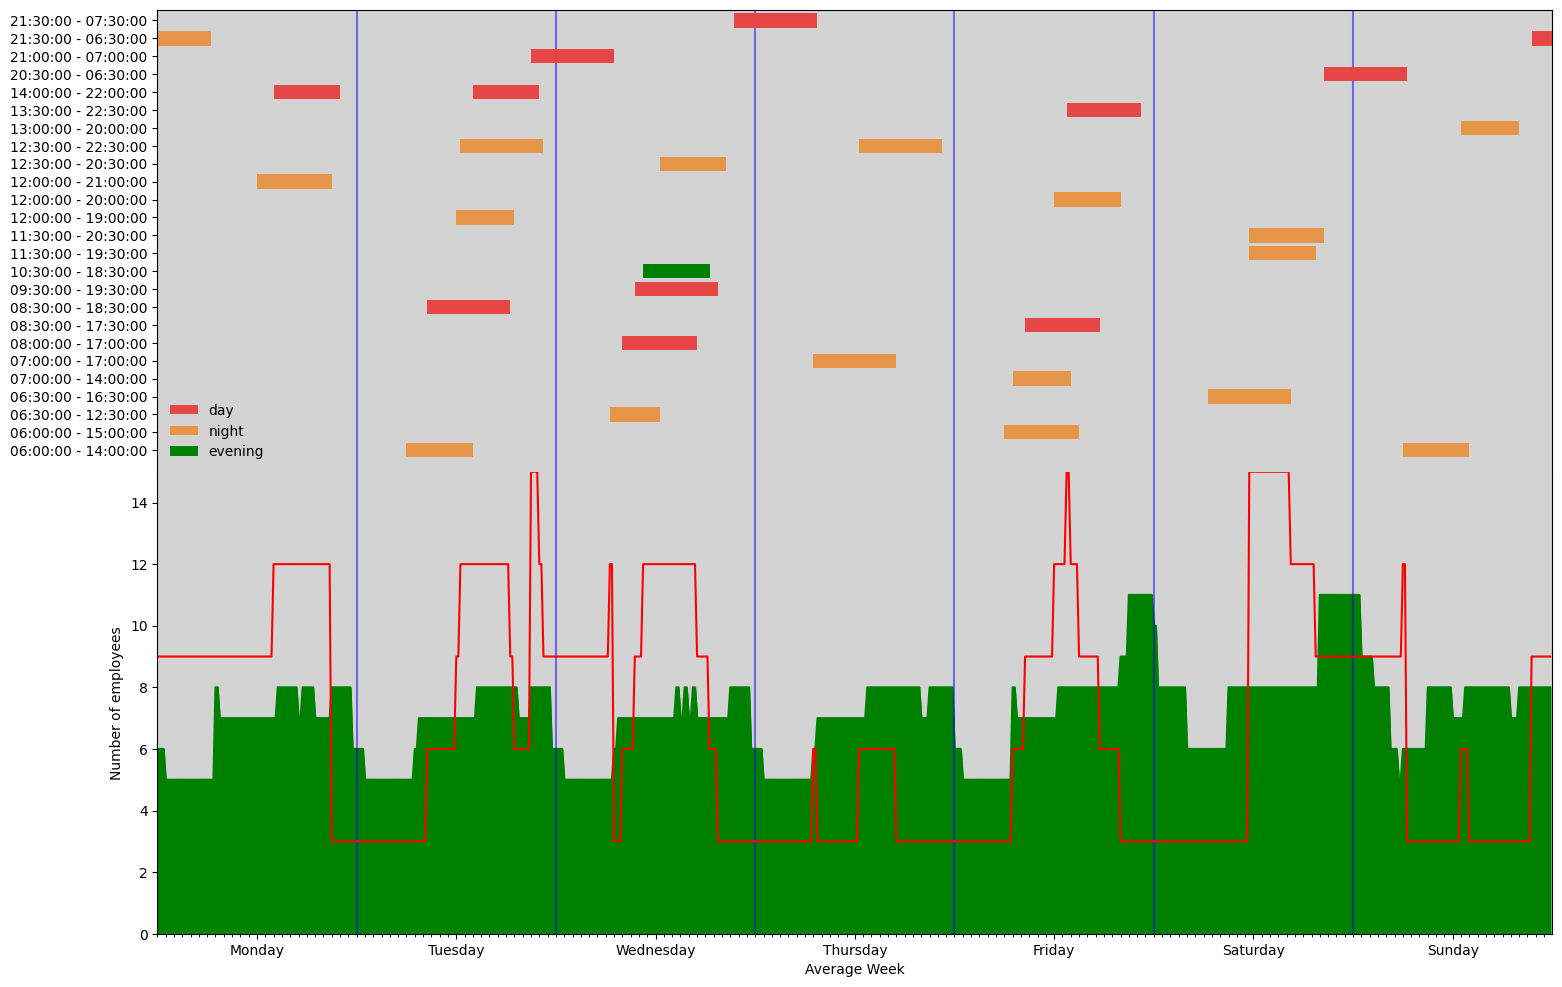

Cost: 416280.0
Average imbalance: 2.800595238095238


In [7]:
demand_ = pd.DataFrame.from_dict(demand.items()).rename(columns = {0: "Date_time", 1 : "Staffing_level"})
demand_.set_index("Date_time", inplace = True)
mapping = {"Monday" : "1", "Tuesday" : "2", "Wednesday" : "3", "Thursday" : "4", "Friday" : "5", "Saturday" : "6", "Sunday" : "7"}
demand_.index = list(map(lambda x : pd.to_datetime("2023-01-0" + mapping[x.split(" ")[0]] + " " + x.split(" ")[1]), demand_.index.tolist()))
demand_ = demand_.sort_index().resample("15min").ffill()

for n, solution in enumerate(Save_Solutions_Here):
    solution = [shift for shift in solution[:-1] if shift[1] > 0]
    results, n_assigned = tabularize_results(solution, shift_stats, ts_horizon, overlap, shift_lenghts, timeframe)
    ts_ = list(forecasts.create_horizon_dates("2023-01-01", 1, 15))
    n_assigned = results[["start_num", "end_num", "staff"]].astype(int).copy()
    n_assigned["coverage"] = n_assigned[["start_num", "end_num"]].apply(lambda df: ts_[df["start_num"] : df["end_num"]], axis = 1)
    n_assigned =  n_assigned.explode("coverage")
    n_assigned = n_assigned.groupby("coverage").agg({"staff":"sum"}).sort_index()
    n_assigned.rename({"staff": "Assigned"}, axis = 1, inplace = True)
    n_assigned = n_assigned.sort_index().resample("15min").ffill()
    n_assigned = pd.merge(n_assigned, demand_, right_index = True, left_index = True, how = "outer").ffill()
    n_assigned.reset_index(drop = False, names = ["date"], inplace = True)
    if n_assigned.Assigned.max() <= max_cap:
        print(n)
        break

schedule_graph = plot_resulting_schedule(results.sort_values("start-end"), n_assigned, 15)
plt.show()
print("Cost: {}\nAverage imbalance: {}".format(*get_final_objs(solution, shift_costs, demand)))

In [ ]:
398412
1.6373626373626373
1.71095238095238095

In [8]:
# cost =  sum(list(map(lambda x : cost_df[x[0]] * x[1], solution)))
tmp = shift_stats.reset_index(names = "Shift_name")[["Shift_name", "Start_end"]].copy()
tmp = pd.merge(pd.DataFrame.from_records(solution).rename(columns = {0:"Shift_name",1:"Assigned", "string" : "Shift_name", "integer" : "Assigned"}), tmp, on = "Shift_name", how = "left")
tmp = tmp.explode("Start_end")
tmp["Start_end"] = tmp.Start_end.apply(lambda y: ts_horizon[y])
tmp["Demand"] = tmp.Start_end.apply(lambda y: demand[y])
tmp = tmp.groupby("Start_end").agg({"Demand" : "mean", "Assigned" : "sum"})
tmp["UnderStaff"] = tmp["Demand"] - tmp["Assigned"]
# return cost, tmp.UnderStaff.mean(), tmp.UnderStaff.abs().max()

In [9]:
tmp["UnderStaff"] = (tmp["Demand"] - tmp["Assigned"]).apply(lambda x: max(x, 0))
tmp["OverStaff"] =  (tmp["Assigned"] - tmp["Demand"]).apply(lambda x: max(x, 0))
print(tmp["UnderStaff"].mean())
print(tmp["OverStaff"].mean())

1.6373626373626373
1.8095238095238095


In [10]:
### DEF ----- 
def get_final_objs(solution, cost_df, demand):
    cost =  sum(list(map(lambda x : cost_df[x[0]] * x[1], solution)))
    tmp = shift_stats.reset_index(names = "Shift_name")[["Shift_name", "Start_end"]].copy()
    tmp = pd.merge(pd.DataFrame.from_records(solution).rename(columns = {0:"Shift_name",1:"Assigned", "string" : "Shift_name", "integer" : "Assigned"}), tmp, on = "Shift_name", how = "left")
    tmp = tmp.explode("Start_end")
    tmp["Start_end"] = tmp.Start_end.apply(lambda y: ts_horizon[y])
    tmp["Demand"] = tmp.Start_end.apply(lambda y: demand[y])
    tmp = tmp.groupby("Start_end").agg({"Demand" : "mean", "Assigned" : "sum"})
    tmp["UnderStaff"] = tmp["Demand"] - tmp["Assigned"]
    return cost, tmp.UnderStaff.mean(), tmp.UnderStaff.abs().max()

print("Cost: {}\nAverage imbalance: {}\nMax Imbalance: {}".format(*get_final_objs(solution, shift_costs, demand)))

Cost: 273124.5
Average imbalance: 1.3272727272727274
Max Imbalance: 8.0


In [ ]:
512.434
584.416
484.776
684.516
503.374
471.734
485.614
508.524
489.600
584.096
485.212
598.236
558.914
671.096
493.078
571.496
545.202
470.346
591.498
637.546
462.492
513.560
425.693
540.038
436.435
525.584
422.222
534.349
439.044
549.318
458.141
511.993
436.716
537.453
431.348
512.641
422.255
512.213
429.014
565.726

### Experiment with Tabu List 3 - Solution Characteristics as Tabu 

In [65]:
##### INITIAL SOLUTION ---------------------------------------------------------------------------------------------------------------------------------------------------
build_initial = []
end = None
iterr = 0
start = f"Monday {str(earliest).zfill(2)}:00:00"
while end != f"Monday {str(earliest).zfill(2)}:00:00":
    pox = list(shift_day_match_start[start])
    shift = rd.sample(pox, 1)[0]
    end = ts_horizon[shift_stats.loc[shift, "Start_end"][-1]]
    while "16:30:00" < end[-8:] < "20:30:00":
        pox.remove(shift)
        shift = rd.sample(pox, 1)[0]
        end = ts_horizon[shift_stats.loc[shift, "Start_end"][-1]]
    start = end
    build_initial.append(shift)
    if "Sunday 20:30:00" <= start < "Sunday 23:00:00":
        break

build_initial.append(list(set(shift_day_match_start[ts_horizon[shift_stats.loc[build_initial[-1], "Start_end"][-1]]]).intersection(set(shift_day_match_end[f"Monday {str(earliest).zfill(2)}:30:00"])))[0])
build_initial = pd.DataFrame(build_initial).rename(columns = {0: "Shift_name"})
build_initial["coverage"] = build_initial["Shift_name"].apply(lambda x: meta_dict[x])
build_initial = build_initial.explode("coverage").reset_index(drop = True)
build_initial["coverage"] = build_initial["coverage"].apply(lambda x : ts_horizon[x])
build_initial = pd.merge(build_initial, Demand, left_on = "coverage", right_index = True, how = "left")
build_initial["Assigned"] = teamsize * (max(build_initial.Staffing_level.mean() // teamsize,1))
build_initial_demand = build_initial.groupby("coverage").agg({"Assigned":"sum", "Staffing_level":"mean", "Assigned":"sum", "Shift_name": "unique"})
build_initial_demand["order"] = list(map(lambda x : ts_horizon.index(x), build_initial_demand.index))
additional_pp = set(map(lambda x: x[0], build_initial_demand.loc[(build_initial_demand.Staffing_level > build_initial_demand.Staffing_level.mean()) & (build_initial_demand.Assigned < build_initial_demand.Staffing_level)].sort_values("order").Shift_name))
build_initial.loc[build_initial.Shift_name.isin(additional_pp), "Assigned"] = teamsize * (max(build_initial.Staffing_level.mean() // teamsize,1)) *2
assert len(build_initial[["Shift_name", "Assigned"]].drop_duplicates()["Shift_name"].value_counts().unique()) == 1
Initial_Solution = []
for shift, assigned in build_initial[["Shift_name", "Assigned"]].drop_duplicates().to_numpy().tolist():
    Initial_Solution.append((shift, assigned))

for unused in set(S).difference(set(map(lambda y: y[0], Initial_Solution))):
    Initial_Solution.append((unused, 0))


ShiftCosts_df = pd.DataFrame(dict(shift_costs), index=[0])
sum_start_int = get_objFunc(Initial_Solution, ShiftCosts_df)

X0 = Initial_Solution
X0 = np.array(X0, dtype = [('string', 'U20'), ('integer', int)])
Initial_For_Final = X0[:] # For printing at the end
print()
# print(f'Initial Solution: {Initial_For_Final}')
# Initial_With_FV = np.array([np.concatenate((Initial_Solution, np.array([("Fitness Value" , get_objFunc(Initial_Solution,ShiftCosts_df))],  dtype = [('string', 'U20'), ('integer', int)])), axis = 0)])

print(f'Initial FV: {sum_start_int}')
# print(f"Initial Demand FV: {create_demand_fv(Initial_With_FV)}")
### RUN ---------------------------------------------------------------------------------------------------------------------------------------------------
Runs = 80
## Tabu List ## 
Length_of_Tabu_List = 20 ##### Change this as part of MDA

moves_config = {0: "ReplaceShifts(X0, dict_replace)",
                1: "ChangeTeamSize(X0, teamsize = teamsize, demand = demand)",
                2: "Number_of_Shifts(X0, teamsize = teamsize, dict_replace = dict_replace, meta_dict = meta_dict)",
                3: "EnsabledMove(X0, teamsize = teamsize, demand = demand, dict_replace = dict_replace ,meta_dict = meta_dict)"}

change_move = 20

Iterations = 1
Tabu_List = []  # Move operator 1  #np.empty((0,len(X0)+1), dtype=[('string', 'U20'), ('integer', int)]) # +1 bc we want to add the fitness value
Save_Solutions_Here = []


# Our move operator is swapping 2 shifts with shifts that covers same timeperiods
dict_replace = dict()
for gene in S:
    cov_shifts = set(t_s_cov[ts_horizon[meta_dict[gene][0]]])
    for tp in meta_dict[gene]:
        cov_shifts = cov_shifts.intersection(set(t_s_cov[ts_horizon[tp]]))
        cov_shifts = cov_shifts.difference(set([gene]))
    if len(cov_shifts) > 0 : 
        dict_replace[gene] = cov_shifts

for Iteration in tqdm(range(Runs)):
    # print()
    # print(f'--> This is the %i' % Iterations,'th Iteration <--')
    # print("Move used: ", moves_config[int(Iteration//change_move)].split("(")[0])
    All_N_for_i, moves_used = eval(moves_config[int(Iteration//change_move)])
    if len(All_N_for_i) == 0:
        if (Iteration + 1)%5 == 0:
            new_len = np.random.randint(10,30)
            if new_len < Length_of_Tabu_List:
                Tabu_List = Tabu_List[:new_len]
            Length_of_Tabu_List = new_len
        Iterations += 1
        continue
    ObjFct_Values_for_N = np.array([np.concatenate((s, np.array([("Fitness Value" , get_objFunc(s,ShiftCosts_df))],  dtype = [('string', 'U20'), ('integer', int)])), axis = 0) for s in All_N_for_i])
    ObjFct_Values_all_N_Ordered = np.array(sorted(ObjFct_Values_for_N, key= lambda x: x[0][1]))
    demand_top_10costs = []
    t = 10
    Current_Solutions = ObjFct_Values_all_N_Ordered[:t] # current best solution
    best = ["Demand Fitness Value", 999999999999999]
    id_best = -1
    for n,s in enumerate(Current_Solutions):
        fv = create_demand_fv(s)
        demand_top_10costs.append((fv, s))
        if fv < best[1]:
            best[1], id_best = fv, n
    Obj_fct_Demand_Values_all_N_ordered = np.array(sorted(demand_top_10costs, key= lambda x: x[0]), dtype=object)
    Current_Solution = Obj_fct_Demand_Values_all_N_ordered[0][1]
    X0 = Current_Solution[:-1]
    # move = neighbour_move(Current_Solution, moves_used)
    TL_Solutions = list(map(lambda d: d[0],Tabu_List))
    while f"{Current_Solution}" in TL_Solutions and len(Obj_fct_Demand_Values_all_N_ordered) > 0 :
        if np.array(sorted(np.array(Save_Solutions_Here, dtype=[('string', 'U20'), ('integer', int)]), key= lambda x: x[0][-1]))[0][-1][1] > Current_Solution[-1][1]: ####### Aspiration criteria
            Tabu_List.remove(Tabu_List[TL_Solutions.index(f"{Current_Solution}")])
            Tabu_List.append((f"{Current_Solution}", Current_Solution[-1][1]))
            X0 = Current_Solution[:-1]
            Iterations += 1
            break
        Obj_fct_Demand_Values_all_N_ordered = Obj_fct_Demand_Values_all_N_ordered[1:]
        Current_Solution = Obj_fct_Demand_Values_all_N_ordered[0][1]
        # move = neighbour_move(Current_Solution, moves_used)
    else:
        if len(Obj_fct_Demand_Values_all_N_ordered) == 0:
            if (Iteration + 1)%5 == 0:
                new_len = np.random.randint(10,30)
                if new_len < Length_of_Tabu_List:
                    Tabu_List = Tabu_List[:new_len]
                Length_of_Tabu_List = new_len
            Iterations += 1
            continue
        else:
            Tabu_List.append((f"{Current_Solution}", Current_Solution[-1]))
            X0 = Current_Solution[:-1]
            Iterations += 1
    
    if len(Tabu_List) > Length_of_Tabu_List:
        Tabu_List = Tabu_List[1:]
    
    Save_Solutions_Here.append(Current_Solution)

    if (Iteration + 1)%5 == 0:
        new_len = np.random.randint(10,30)
        if new_len < Length_of_Tabu_List:
            Tabu_List = Tabu_List[:new_len]
        Length_of_Tabu_List = new_len

best_solution = 99
best_demand = 99
for n, solution in enumerate(Save_Solutions_Here):
    fitness_demand = create_demand_fv(solution)/len(ts_horizon)
    fitness_cost = solution[-1]
    if (fitness_cost[1] <= 427455 * 1.1) and (fitness_demand <= 1.8571 * 1.1) :
        if fitness_demand < best_demand:
            best_solution = solution[:-1]
            best_demand = fitness_demand
            best_cost = fitness_cost
final_solution = [shift for shift in best_solution if shift[1] > 0]
print("Demand FV:",best_demand)
print("Cost:", best_cost)
print("Solution:")
for i in final_solution:
    print(i)


Initial FV: 269964.0


100%|██████████| 80/80 [01:39<00:00,  1.24s/it]


Demand FV: 1.8303571428571428
Cost: ('Fitness Value', 303324)
Solution:
('Shift-558', 6)
('Shift-562', 6)
('Shift-566', 6)
('Shift-43', 6)
('Shift-581', 6)
('Shift-333', 6)
('Shift-212', 6)
('Shift-598', 6)
('Shift-216', 6)
('Shift-363', 6)
('Shift-615', 6)
('Shift-619', 6)
('Shift-108', 6)
('Shift-634', 6)
('Shift-112', 6)
('Shift-651', 6)
('Shift-292', 6)
('Shift-670', 6)
('Shift-295', 6)
('Shift-649', 6)
('Shift-655', 6)
